# Exploratory Data Analysis

Random preliminary analysis on the NBA boxscore (df_box) and play by play (df_pbp) datasets

## Table of Contents

### Import and clean the Data

In [87]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [88]:
#import the boxscores dataset
df_box = pd.read_csv('data/df_box_scores_2000_2018_clean.csv').drop(columns=['Unnamed: 0'])
#import the dataset with links, dates, and whether the game was in the playoffs or regular season
df_playoffs = pd.read_csv('data/df_playoff_dates_1959_2019_clean.csv').rename(columns={'playoff_dates':'playoff_date'})

In [89]:
df_box.shape
df_playoffs.shape

(531441, 42)

(61, 3)

In [90]:
#change the playoff date to datetime format
df_playoffs['playoff_date'] = pd.to_datetime(df_playoffs['playoff_date'])

In [91]:
#get rid of the full URL in the 'link' column 
df_box['link'] = df_box['link'].apply(lambda x: x.split('boxscores/')[1].split('.html')[0])

In [92]:
#fix some errors in the data
df_box.loc[313944:313947, 'team'] = 'Dallas Mavericks'
df_box.loc[206215:206218, 'team'] = 'Philadelphia 76ers'

In [93]:
#create array to store seasons to iterate through in the for loop
seasons = df_box['season'].unique()

#iterate through each season, add in column describing if the season is in 
df_box_by_season = pd.DataFrame()
for season in seasons:
    df_season = df_box[df_box['season']==season]
    df_season = df_season.merge(df_playoffs[['season','playoff_date']], how='left', on='season')
    df_season['date'] = pd.to_datetime(df_season['date'])
    #determine if the date in the game is earlier than the corresponding season's playoff date
    df_season['time_of_year'] = np.where(df_season['playoff_date'] >= df_season['date'], 'regular_season', 'playoffs')
    df_box_by_season = df_box_by_season.append(df_season)

In [94]:
#get rid of the playoff date column and 
df_box = df_box_by_season.drop(columns=['playoff_date'])

In [95]:
df_box.head()

,player,team,team_key,mp,fg,fga,fg%,3p,3pa,3p%,...,TOV%,USG%,ORtg,DRtg,key,game,date,season,link,time_of_year
0,harprma01,Utah Jazz,away,30:00,6.0,12.0,0.500,0.0,0.0,NaN,...,17.0,26.9,109.0,90.0,2003_4174,Utah Jazz at Memphis Grizzlies,2002-12-22,2003,200212220MEM,regular_season
1,malonka01,Utah Jazz,away,29:00,6.0,7.0,0.857,0.0,0.0,NaN,...,17.2,18.3,146.0,71.0,2003_4174,Utah Jazz at Memphis Grizzlies,2002-12-22,2003,200212220MEM,regular_season
2,stockjo01,Utah Jazz,away,21:00,1.0,3.0,0.333,0.0,0.0,NaN,...,13.3,16.4,142.0,77.0,2003_4174,Utah Jazz at Memphis Grizzlies,2002-12-22,2003,200212220MEM,regular_season
3,ostergr01,Utah Jazz,away,19:00,1.0,3.0,0.333,0.0,0.0,NaN,...,0.0,7.2,117.0,88.0,2003_4174,Utah Jazz at Memphis Grizzlies,2002-12-22,2003,200212220MEM,regular_season
4,cheanca01,Utah Jazz,away,17:00,2.0,5.0,0.400,0.0,0.0,NaN,...,28.6,18.8,70.0,97.0,2003_4174,Utah Jazz at Memphis Grizzlies,2002-12-22,2003,200212220MEM,regular_season


# Begin Random EDA

### Do the number of fouls called change from the regular season to the playoffs?

In [96]:
#Get the total number of fouls per game, per season and put it to another dataset 
df_fouls = df_box.groupby(['link', 'time_of_year','season'])['pf'].sum().reset_index()

In [97]:
df_fouls.head()

,link,time_of_year,season,pf
0,199911020CHH,regular_season,2000,56.0
1,199911020DAL,regular_season,2000,48.0
2,199911020DEN,regular_season,2000,45.0
3,199911020HOU,regular_season,2000,49.0
4,199911020LAC,regular_season,2000,45.0


#### Get the average number of fouls per game in the regular season versus the playoffs for all seasons

In [98]:
#group the df_fouls dataset by the time of year and season, and get the average number of fouls in each set.
df_pf_per_year = df_fouls.groupby(['time_of_year','season'])['pf'].mean().reset_index()

#filter out the regular season and playoffs
regular_pf = df_pf_per_year[df_pf_per_year['time_of_year']=='regular_season'].drop(columns=['time_of_year']).rename(columns={'pf':'pf_regular'})
playoff_pf = df_pf_per_year[df_pf_per_year['time_of_year']=='playoffs'].drop(columns=['time_of_year']).rename(columns={'pf':'pf_playoffs'})

#merge the datasets together so they can be compared by row
df_pf_per_year = pd.merge(regular_pf, playoff_pf, how='left',on='season')

#add in another row that just subtracts the fouls per game between the regular season and the playoffs
df_pf_per_year['pf_difference'] = df_pf_per_year['pf_regular'] - df_pf_per_year['pf_playoffs']
df_pf_per_year.head(10)

,season,pf_regular,pf_playoffs,pf_difference
0,2000,46.606035,48.464789,-1.858754
1,2001,44.692372,45.373134,-0.680762
2,2002,42.439229,47.850746,-5.411517
3,2003,43.522613,48.722892,-5.200279
4,2004,42.910310,46.487179,-3.576869
5,2005,45.258509,47.037500,-1.778991
6,2006,45.518639,48.058824,-2.540185
7,2007,44.444895,44.320000,0.124895
8,2008,42.055105,45.243902,-3.188797
9,2009,42.074554,45.753086,-3.678532


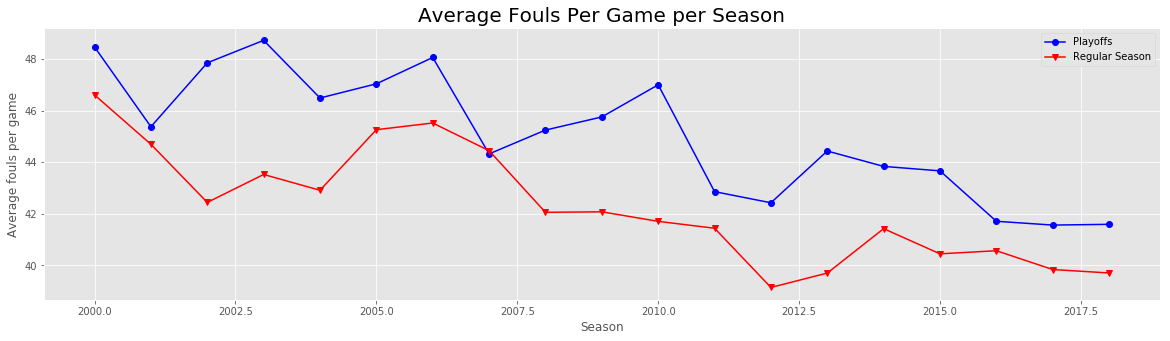

In [99]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df_pf_per_year['season'], df_pf_per_year['pf_playoffs'], color='blue', label='Playoffs', marker='o')
ax.plot(df_pf_per_year['season'], df_pf_per_year['pf_regular'], color='red', label='Regular Season', marker='v')
ax.set_xlabel('Season')
ax.set_ylabel('Average fouls per game')
ax.set_title('Average Fouls Per Game per Season',size=20)
ax.legend()
plt.show();

#### There appears to be a higher number of fouls called per game in the playoffs than in the regular season by about three fouls, so yes, they do change.

In [100]:
df_pf_per_year['pf_difference'].mean()

-2.784394952643757

### How has three point shooting changed over time? 

#### Looking at changes of 3-point field goals for all teams by season

In [101]:
df_3fg = df_box.groupby(['season','link'])['pts','fg','fga','3p','3pa'].sum().reset_index()

In [102]:
df_3fg = df_3fg.groupby('season')['pts','fg','fga','3p','3pa'].mean().reset_index()

In [103]:
df_3fg['3p%_of_fg'] = df_3fg['3pa'] / df_3fg['fga']

In [104]:
#create a function for generating the line plot
def plot_time_series(axes, x, y, color, marker, xlabel, ylabel):
    axes.plot(x, y, color=color, marker = marker)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel, color=color)
    axes.tick_params('y', colors = color)

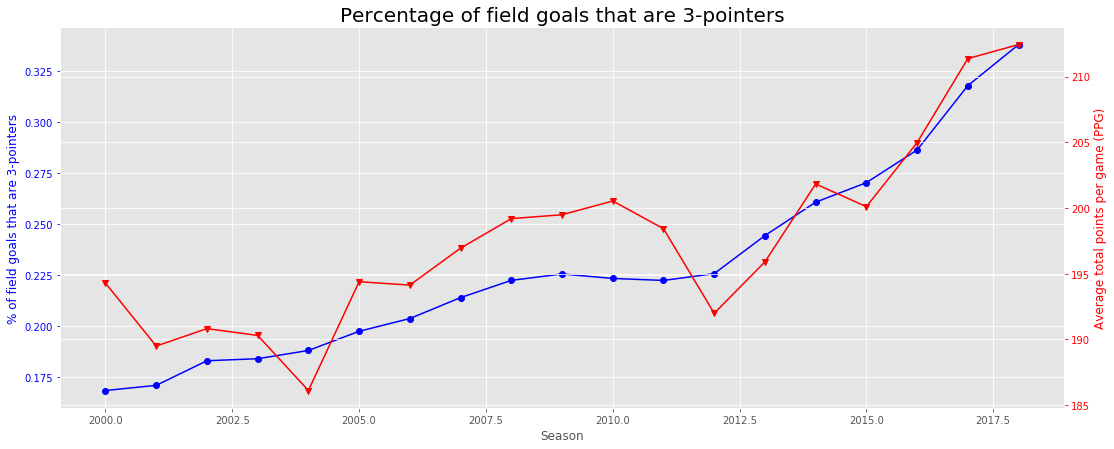

In [157]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(18,7))
plot_time_series(ax, df_3fg['season'], df_3fg['3p%_of_fg'], 'b', 'o', 'Season', '% of field goals that are 3-pointers')

ax2 = ax.twinx()
plot_time_series(ax2, df_3fg['season'], df_3fg['pts'], 'r', 'v', 'Season', 'Average total points per game (PPG)')

ax.set_title('Percentage of field goals that are 3-pointers',size=20)
plt.show();

### Histogram
Histogram comparing the average PPG per team in the 2001 season versus 2018 season

In [159]:
#create datasets for the 2001 and 2018 seasons
df_box_2001 = df_box[df_box['season']==2001]
df_box_2018 = df_box[df_box['season']==2018]

In [163]:
#group and sum each dataset by season, game, and team
df_box_2001 = df_box_2001.groupby(['season','link','team'])['pts','fg','fga','3p','3pa'].sum().reset_index()
df_box_2018 = df_box_2018.groupby(['season','link','team'])['pts','fg','fga','3p','3pa'].sum().reset_index()

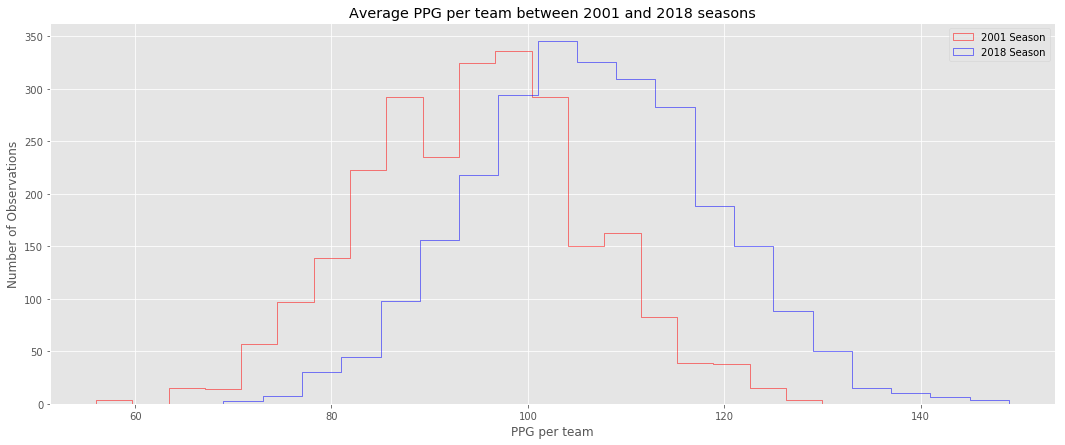

In [176]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(18,7))
# the histogram of the data
ax.set_title('Average PPG per team between 2001 and 2018 seasons')
ax.hist(df_box_2001['pts'], bins=20, color='r', label='2001 Season', histtype='step')
ax.hist(df_box_2018['pts'], bins=20, color='b', label='2018 Season', histtype='step')
ax.set_ylabel('Number of Observations')
ax.set_xlabel('PPG per team')
ax.legend()
plt.show();

The histogram shows the difference in the points scored in games between the 2001 and 2018 season; there are more games in the 2018 season with a higher point total per team on average than games in the 2001 season.

### Bee Swarm Plot
Using a bee swarm plot for total PPG per team for season doesn't work well, since there are over 1000 observations per season, and the plot just doesn't look great. To show this here's a bee swarm plot for just the 2001 season:

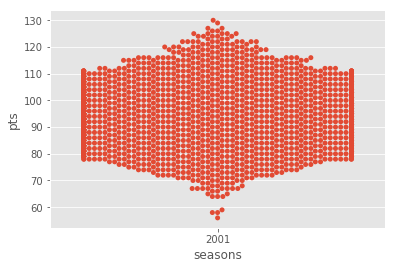

In [192]:
import seaborn as sns
ax = sns.swarmplot(x='season', y='pts', data=df_box_2001)
# Label the axes
ax = plt.ylabel('pts')
ax = plt.xlabel('seasons')
# Show the plot
plt.show()

Instead, I'll use an Empirical Cumulative Distribution Function (ECDF) in the next section, however, in the meantime I'm going to group together the average PPG per season for a basketball player. I'm going to use Kobe Bryant. 

In [217]:
df_kobe = df_box[df_box['player']=='bryanko01']

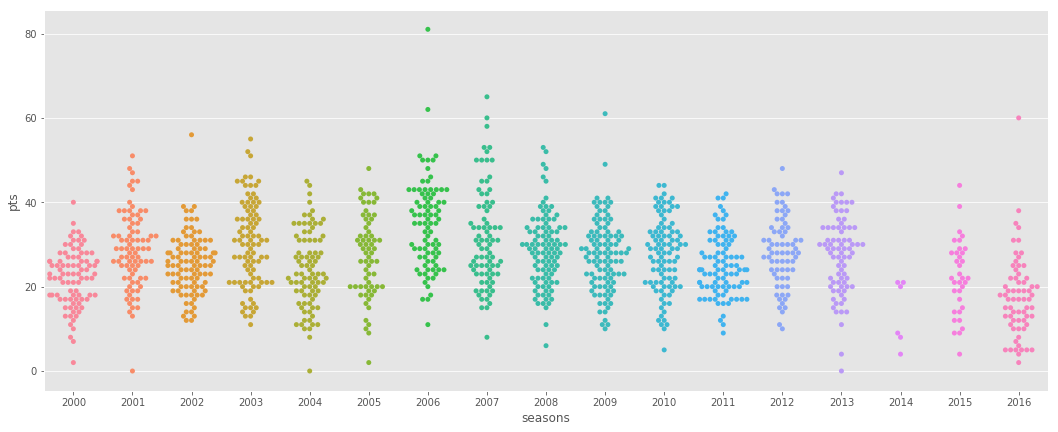

In [279]:
fig, ax = plt.subplots(figsize=(18,7))
ax = sns.swarmplot(x='season', y='pts', data=df_kobe)
# Label the axes
ax = plt.ylabel('pts')
ax = plt.xlabel('seasons')
# Show the plot
plt.show()

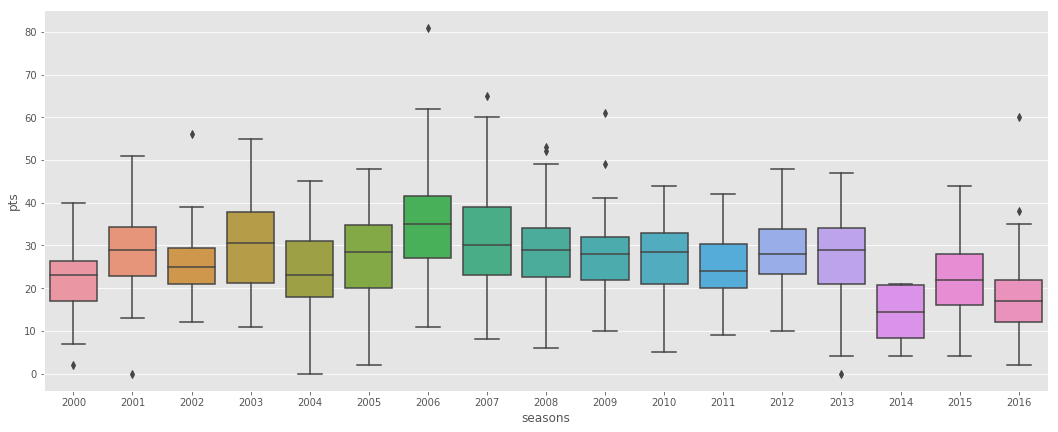

In [280]:
#Shwoing the same data as a boxplot
fig, ax = plt.subplots(figsize=(18,7))
ax = sns.boxplot(x='season', y='pts', data=df_kobe)
# Label the axes
ax = plt.ylabel('pts')
ax = plt.xlabel('seasons')
# Show the plot
plt.show()

### Empirical Cumulative Distribution Function (ECDF) 

In [244]:
#create a function to group the arrays within the dataset by season
def ecdf_grouper(dataframe, season, *columns_to_aggregate):
    #filter season
    dataframe = dataframe[dataframe['season'] == season]
    #group by season and selected columns
    dataframe = dataframe.groupby(['link','team','season'])[columns_to_aggregate].sum().reset_index()
    return dataframe

In [261]:
df_2018 = ecdf_grouper(df_box, 2018, 'pts')
df_2010 = ecdf_grouper(df_box, 2010, 'pts')
df_2001 = ecdf_grouper(df_box, 2001, 'pts')

In [258]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    
    return x, y

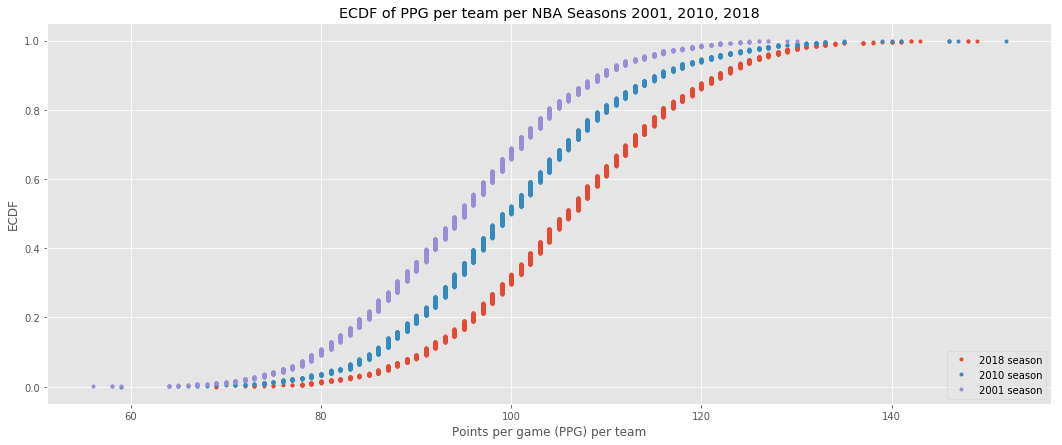

In [274]:
# Compute ECDF for versicolor data: x_vers, y_vers
x_18, y_18 = ecdf(df_2018['pts'])
x_10, y_10 = ecdf(df_2010['pts'])
x_01, y_01 = ecdf(df_2001['pts'])

# Generate plot
fig, ax = plt.subplots(figsize=(18,7))

ax = plt.plot(x_18, y_18, marker='.',linestyle='none')
ax = plt.plot(x_10, y_10, marker='.',linestyle='none')
ax = plt.plot(x_01, y_01, marker='.',linestyle='none')

# Label the axes
ax = plt.ylabel('ECDF')
ax = plt.xlabel('Points per game (PPG) per team')
ax = plt.title('ECDF of PPG per team for NBA Seasons 2001, 2010, 2018')
plt.legend(('2018 season', '2010 season', '2001 season'), loc='lower right')

# Display the plot
plt.show();


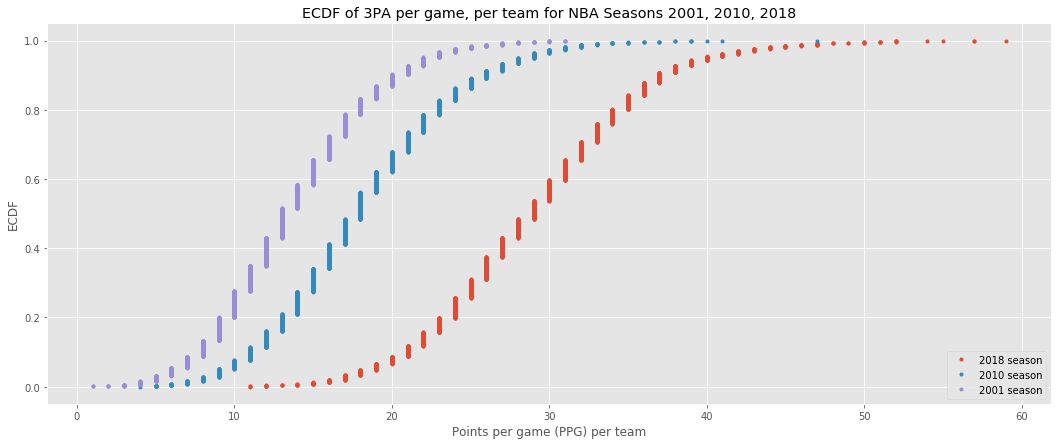

In [277]:
#applying the same thing, except for 
df_2018 = ecdf_grouper(df_box, 2018, '3pa')
df_2010 = ecdf_grouper(df_box, 2010, '3pa')
df_2001 = ecdf_grouper(df_box, 2001, '3pa')

# Compute ECDF for versicolor data: x_vers, y_vers
x_18, y_18 = ecdf(df_2018['3pa'])
x_10, y_10 = ecdf(df_2010['3pa'])
x_01, y_01 = ecdf(df_2001['3pa'])

# Generate plot
fig, ax = plt.subplots(figsize=(18,7))

ax = plt.plot(x_18, y_18, marker='.',linestyle='none')
ax = plt.plot(x_10, y_10, marker='.',linestyle='none')
ax = plt.plot(x_01, y_01, marker='.',linestyle='none')

# Label the axes
ax = plt.ylabel('ECDF')
ax = plt.xlabel('Points per game (PPG) per team')
ax = plt.title('ECDF of 3PA per game, per team for NBA Seasons 2001, 2010, 2018')
plt.legend(('2018 season', '2010 season', '2001 season'), loc='lower right')

# Display the plot
plt.show();


### Box Plots

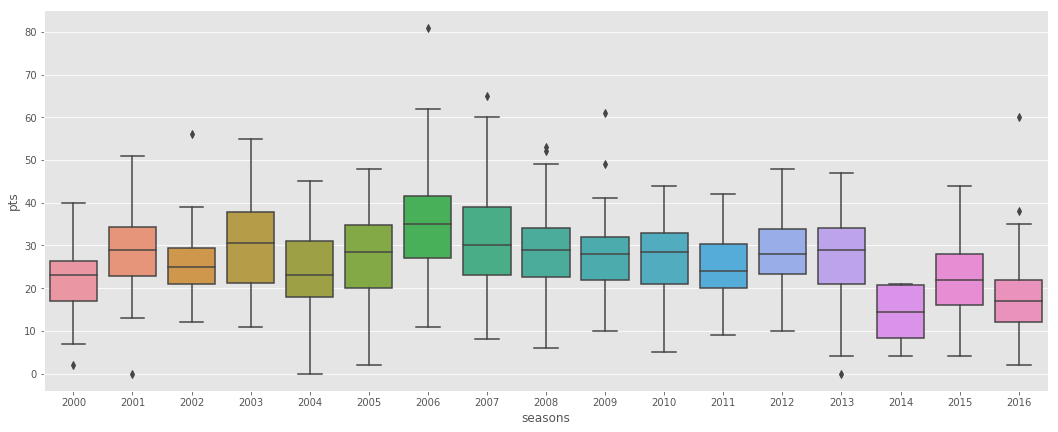

In [278]:
fig, ax = plt.subplots(figsize=(18,7))
ax = sns.boxplot(x='season', y='pts', data=df_kobe)
# Label the axes
ax = plt.ylabel('pts')
ax = plt.xlabel('seasons')
# Show the plot
plt.show()